# Importing and Setting Up Config.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
CONFIG = {"rmax" : 6, "seed" : 21}
torch.manual_seed(CONFIG["seed"])

# Capped-ReLU

In [77]:
def ReLU(x):
    return torch.clamp(x, min=0, max=CONFIG["rmax"])

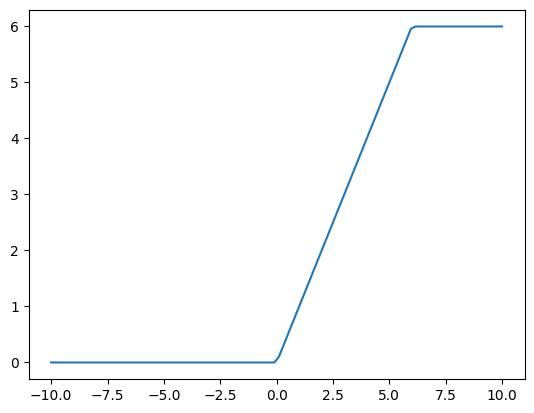

In [78]:
x = torch.tensor(np.linspace(-10,10,100))
y = ReLU(x)
plt.plot(x,y)

# Membership Functions

In [79]:
def left_open(x):
    d = CONFIG["rmax"] / 2
    c = d / 3

    result = torch.zeros_like(x)
    
    result[x < c] = 1.0
    
    mask = (x >= c) & (x <= d)
    result[mask] = (d - x[mask]) / (d - c)
    
    return result

def triangle(x):
    a = CONFIG["rmax"] / 4
    m = CONFIG["rmax"] / 2
    b = a + m

    result = torch.zeros_like(x)
    
    mask1 = (x >= a) & (x < m)
    mask2 = (x >= m) & (x <= b)
    
    result[mask1] = (x[mask1] - a) / (m - a)
    result[mask2] = (b - x[mask2]) / (b - m)
    
    return result

def right_open(x):
    r = CONFIG["rmax"] / 2
    q = r + CONFIG["rmax"] / 4

    result = torch.zeros_like(x)
    
    mask = (x >= r) & (x <= q)
    result[mask] = (x[mask] - r) / (q - r)
    
    result[x > q] = 1.0
    
    return result

def gaussian(x):
    sigma = CONFIG["rmax"] / 10
    c = CONFIG["rmax"] / 2

    return torch.exp(-0.5 * ((x - c) / sigma) ** 2)

def sigmoid(x):
    a = CONFIG["rmax"] / 3
    c = CONFIG["rmax"] / 2

    return 1 / (1 + torch.exp(-a * (x - c)))

def bell_shaped(x):
    a = CONFIG["rmax"] / 10
    b = 2
    c = CONFIG["rmax"] / 2

    return 1 / (1 + torch.abs((x - c) / a) ** (2 * b))

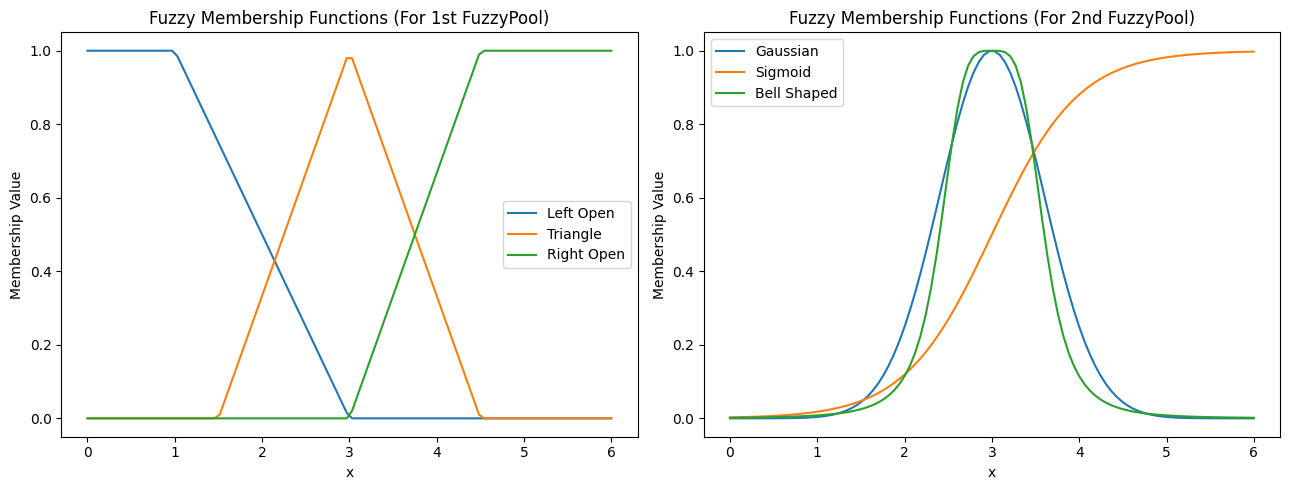

In [80]:
x = torch.tensor(np.linspace(0,6,100))
y1 = left_open(x)
y2 = triangle(x)
y3 = right_open(x)
y4 = gaussian(x)
y5 = sigmoid(x)
y6 = bell_shaped(x)

plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y1, label='Left Open')
plt.plot(x, y2, label='Triangle')
plt.plot(x, y3, label='Right Open')
plt.title("Fuzzy Membership Functions (For 1st FuzzyPool)")
plt.xlabel("x")
plt.ylabel("Membership Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, y4, label='Gaussian')
plt.plot(x, y5, label='Sigmoid')
plt.plot(x, y6, label='Bell Shaped')
plt.title("Fuzzy Membership Functions (For 2nd FuzzyPool)")
plt.xlabel("x")
plt.ylabel("Membership Value")
plt.legend()

plt.tight_layout()
plt.show()

# Fast Vectorized Implementation using GPU

In [ ]:
class FuzzyPooling(nn.Module):
    def __init__(self, kernel_size, stride, mu1, mu2, mu3):
        super(FuzzyPooling, self).__init__()
        self.mu1 = mu1
        self.mu2 = mu2
        self.mu3 = mu3
        self.kernel_size = kernel_size
        self.stride = stride
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def algebraic_sum(self, val1, val2):
        return val1 + val2 - val1 * val2

    def extract_patches(self, volume, padding='same'):
        batch_size, channels, height, width = volume.shape
        kernel_size = self.kernel_size
        stride = self.stride

        if padding == 'same':
            pad_width = ((width - 1) // stride + 1) * stride - width
            pad_height = ((height - 1) // stride + 1) * stride - height
            volume = torch.nn.functional.pad(
                volume, 
                (pad_width // 2, pad_width - pad_width // 2, pad_height // 2, pad_height - pad_height // 2), 
                mode='constant', 
                value=0
            )

        _, _, new_height, new_width = volume.shape

        num_patches_h = (new_height - kernel_size) // stride + 1
        num_patches_w = (new_width - kernel_size) // stride + 1

        patches = volume.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
        patches = patches.contiguous().view(batch_size, channels, num_patches_h, num_patches_w, kernel_size, kernel_size)

        return patches

    def forward(self, beta):
        beta = beta.to(self.device)
        batch_size, channels, height, width = beta.shape

        # Extracting patches 
        patches = self.extract_patches(beta, padding='same')
        out_height, out_width = patches.shape[2], patches.shape[3]

        p_dash = torch.zeros(batch_size, channels, out_height, out_width, device=self.device)

        # Computing membership functions
        pi_1 = self.mu1(patches) 
        pi_2 = self.mu2(patches)
        pi_3 = self.mu3(patches)

        # Computing the sum of memberships 
        spi_1 = pi_1.sum(dim=(-1, -2))  
        spi_2 = pi_2.sum(dim=(-1, -2))
        spi_3 = pi_3.sum(dim=(-1, -2))

        # Calculating algebraic sums 
        spi_1 = self.algebraic_sum(spi_1, spi_1)
        spi_2 = self.algebraic_sum(spi_2, spi_2)
        spi_3 = self.algebraic_sum(spi_3, spi_3)

        # Selecting the best membership function
        max_indices = torch.argmax(torch.stack([spi_1, spi_2, spi_3], dim=-1), dim=-1) 
        pi_dash = torch.empty_like(patches)
        for k in range(3):
            pi_dash[max_indices == k] = [pi_1[max_indices == k], pi_2[max_indices == k], pi_3[max_indices == k]][k]

        # Defuzzification using Center of Gravity (CoG)
        numerator = (pi_dash * patches).sum(dim=(-1, -2))  
        denominator = pi_dash.sum(dim=(-1, -2)) + 1e-9  

        p_dash = numerator / denominator 
        
        return p_dash

# Previous Implementation (SLOW)

In [82]:
# #------------------------------------------------
# # (~3mins per forward pass)
# #------------------------------------------------
# #     def forward(self, beta):
# #         beta = beta.to(self.device)
# #         batch_size, channels, height, width = beta.shape

# #         patches = self.extract_patches(beta, padding='same')
# #         out_height, out_width = patches.shape[2], patches.shape[3]

# #         p_dash = torch.zeros(batch_size, channels, out_height, out_width, device=self.device)

# #         for i in tqdm(range(out_height)):
# #             for j in range(out_width):
# #                 patch = patches[:, :, i, j] 

# #                 pi_1 = torch.zeros_like(patch, device=self.device)
# #                 spi_1 = torch.zeros(batch_size, channels, device=self.device)
# #                 pi_2 = torch.zeros_like(patch, device=self.device)
# #                 spi_2 = torch.zeros(batch_size, channels, device=self.device)
# #                 pi_3 = torch.zeros_like(patch, device=self.device)
# #                 spi_3 = torch.zeros(batch_size, channels, device=self.device)

# #                 for batch in range(batch_size):
# #                     for channel in range(channels):
# #                         pi_1[batch, channel] = self.mu1(patch[batch, channel])
# #                         spi_1[batch, channel] = self.algebraic_sum(pi_1[batch, channel].sum(), spi_1[batch, channel])

# #                         pi_2[batch, channel] = self.mu2(patch[batch, channel])
# #                         spi_2[batch, channel] = self.algebraic_sum(pi_2[batch, channel].sum(), spi_2[batch, channel])

# #                         pi_3[batch, channel] = self.mu3(patch[batch, channel])
# #                         spi_3[batch, channel] = self.algebraic_sum(pi_3[batch, channel].sum(), spi_3[batch, channel])

# #                 pi_dash = torch.zeros_like(patch, device=self.device)
# #                 for batch in range(batch_size):
# #                     for channel in range(channels):
# #                         max_index = torch.argmax(torch.tensor([spi_1[batch, channel], spi_2[batch, channel], spi_3[batch, channel]], device=self.device))
# #                         pi_dash[batch, channel] = [pi_1[batch, channel], pi_2[batch, channel], pi_3[batch, channel]][max_index]

# #                 for batch in range(batch_size):
# #                     for channel in range(p.shape[0]):
# #                         numerator = 0
# #                         denominator = 0
# #                         for i in range(p.shape[1]):
# #                             for j in range(p.shape[2]):
# #                                 numerator += pi_dash[channel][i][j] * p[channel][i][j]
# #                                 denominator += pi_dash[channel][i][j]
# #                         p_dash[channel] = numerator / denominator if denominator != 0 else 0

# #         return p_dash

# Loading the MNIST Dataset

In [83]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model Architectures

In [84]:
CONFIG["projMaxPool"] = 6 * 11 * 11
CONFIG["projAvgPool"] = 6 * 11 * 11
CONFIG["projFuzzyPool"] = 6 * 11 * 11

## MaxPool

In [85]:
class LeNetMaxPooling(nn.Module):
    def __init__(self):
        super(LeNetMaxPooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(CONFIG["projMaxPool"], 10)

    def forward(self, x):
        x = ReLU(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

## AveragePool

In [86]:
class LeNetAvgPooling(nn.Module):
    def __init__(self):
        super(LeNetAvgPooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(CONFIG["projAvgPool"], 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

## FuzzyPool 
```(mu1 : left_open, mu2 : triangle, mu3 : right_open)```

In [87]:
class LeNetFuzzyPooling(nn.Module):
    def __init__(self):
        super(LeNetFuzzyPooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = FuzzyPooling(3, 2, left_open, triangle, right_open)
        self.fc1 = nn.Linear(CONFIG["projFuzzyPool"], 10)

    def forward(self, x):
        x = ReLU(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

## FuzzyPool 
```(mu1 : gaussian, mu2 : sigmoid, mu3 : bell_shaped)```

In [88]:
class LeNetFuzzyPoolingNewMu(nn.Module):
    def __init__(self):
        super(LeNetFuzzyPoolingNewMu, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = FuzzyPooling(3, 2, gaussian, sigmoid, bell_shaped)
        self.fc1 = nn.Linear(CONFIG["projFuzzyPool"], 10)

    def forward(self, x):
        x = ReLU(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

## FuzzyPool (Center-Focused)
```(mu1 : gaussian, mu2 : triangle, mu3 : bell_shaped)```

In [89]:
class LeNetFuzzyPoolingCenter(nn.Module):
    def __init__(self):
        super(LeNetFuzzyPoolingCenter, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = FuzzyPooling(3, 2, gaussian, triangle, bell_shaped)
        self.fc1 = nn.Linear(CONFIG["projFuzzyPool"], 10)

    def forward(self, x):
        x = ReLU(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

## He Initialization

In [90]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Training and Testing Models

In [91]:
def train(model, device, train_loader, optimizer, epoch, history):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 500 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    avg_loss = epoch_loss / len(train_loader)
    history.append(avg_loss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

In [92]:
model_maxpool = LeNetMaxPooling().to(device)
model_maxpool.apply(initialize_weights)
optimizer_maxpool = optim.SGD(model_maxpool.parameters(), lr=0.01, momentum=0.9)
history_maxpool = []
for epoch in range(1, 6):
    train(model_maxpool, device, train_loader, optimizer_maxpool, epoch, history_maxpool)
    test(model_maxpool, device, test_loader)

Train Epoch: 1 [0/60000] Loss: 2.341618
Train Epoch: 1 [16000/60000] Loss: 1.605396
Train Epoch: 1 [32000/60000] Loss: 1.596564
Train Epoch: 1 [48000/60000] Loss: 1.615863
Average loss: 1.5924, Accuracy: 8707/10000 (87.07%)

Train Epoch: 2 [0/60000] Loss: 1.541616
Train Epoch: 2 [16000/60000] Loss: 1.698154
Train Epoch: 2 [32000/60000] Loss: 1.617573
Train Epoch: 2 [48000/60000] Loss: 1.495483
Average loss: 1.5844, Accuracy: 8771/10000 (87.71%)

Train Epoch: 3 [0/60000] Loss: 1.523568
Train Epoch: 3 [16000/60000] Loss: 1.585884
Train Epoch: 3 [32000/60000] Loss: 1.616334
Train Epoch: 3 [48000/60000] Loss: 1.685895
Average loss: 1.5829, Accuracy: 8786/10000 (87.86%)

Train Epoch: 4 [0/60000] Loss: 1.614763
Train Epoch: 4 [16000/60000] Loss: 1.574495
Train Epoch: 4 [32000/60000] Loss: 1.583696
Train Epoch: 4 [48000/60000] Loss: 1.579642
Average loss: 1.5800, Accuracy: 8813/10000 (88.13%)

Train Epoch: 5 [0/60000] Loss: 1.709059
Train Epoch: 5 [16000/60000] Loss: 1.617568
Train Epoch: 5 [

### Best Accuracy : ```88.44 %```

In [93]:
model_avgpool = LeNetAvgPooling().to(device)
model_avgpool.apply(initialize_weights)
optimizer_avgpool = optim.SGD(model_avgpool.parameters(), lr=0.01, momentum=0.9)
history_avgpool = []
for epoch in range(1, 6):
    train(model_avgpool, device, train_loader, optimizer_avgpool, epoch, history_avgpool)
    test(model_avgpool, device, test_loader)

Train Epoch: 1 [0/60000] Loss: 2.309760
Train Epoch: 1 [16000/60000] Loss: 1.804285
Train Epoch: 1 [32000/60000] Loss: 1.779464
Train Epoch: 1 [48000/60000] Loss: 1.851872
Average loss: 1.7865, Accuracy: 6759/10000 (67.59%)

Train Epoch: 2 [0/60000] Loss: 1.740519
Train Epoch: 2 [16000/60000] Loss: 1.872134
Train Epoch: 2 [32000/60000] Loss: 1.504598
Train Epoch: 2 [48000/60000] Loss: 1.693881
Average loss: 1.7732, Accuracy: 6860/10000 (68.60%)

Train Epoch: 3 [0/60000] Loss: 1.875706
Train Epoch: 3 [16000/60000] Loss: 1.772463
Train Epoch: 3 [32000/60000] Loss: 1.708318
Train Epoch: 3 [48000/60000] Loss: 1.679047
Average loss: 1.7027, Accuracy: 7624/10000 (76.24%)

Train Epoch: 4 [0/60000] Loss: 1.692831
Train Epoch: 4 [16000/60000] Loss: 1.620349
Train Epoch: 4 [32000/60000] Loss: 1.779581
Train Epoch: 4 [48000/60000] Loss: 1.593143
Average loss: 1.6830, Accuracy: 7775/10000 (77.75%)

Train Epoch: 5 [0/60000] Loss: 1.671123
Train Epoch: 5 [16000/60000] Loss: 1.570919
Train Epoch: 5 [

### Best Accuracy : ```87.13 %```

In [94]:
model_fuzzypool = LeNetFuzzyPooling().to(device)
model_fuzzypool.apply(initialize_weights)
optimizer_fuzzypool = optim.SGD(model_fuzzypool.parameters(), lr=0.01, momentum=0.9)
history_fuzzypool = []
for epoch in range(1, 6):
    train(model_fuzzypool, device, train_loader, optimizer_fuzzypool, epoch, history_fuzzypool)
    test(model_fuzzypool, device, test_loader)

Train Epoch: 1 [0/60000] Loss: 2.259332
Train Epoch: 1 [16000/60000] Loss: 1.681158
Train Epoch: 1 [32000/60000] Loss: 1.630670
Train Epoch: 1 [48000/60000] Loss: 1.560622
Average loss: 1.6052, Accuracy: 8617/10000 (86.17%)

Train Epoch: 2 [0/60000] Loss: 1.614082
Train Epoch: 2 [16000/60000] Loss: 1.571439
Train Epoch: 2 [32000/60000] Loss: 1.566735
Train Epoch: 2 [48000/60000] Loss: 1.673963
Average loss: 1.6022, Accuracy: 8627/10000 (86.27%)

Train Epoch: 3 [0/60000] Loss: 1.507253
Train Epoch: 3 [16000/60000] Loss: 1.669662
Train Epoch: 3 [32000/60000] Loss: 1.639797
Train Epoch: 3 [48000/60000] Loss: 1.656619
Average loss: 1.5971, Accuracy: 8671/10000 (86.71%)

Train Epoch: 4 [0/60000] Loss: 1.563795
Train Epoch: 4 [16000/60000] Loss: 1.645452
Train Epoch: 4 [32000/60000] Loss: 1.518590
Train Epoch: 4 [48000/60000] Loss: 1.685307
Average loss: 1.5290, Accuracy: 9372/10000 (93.72%)

Train Epoch: 5 [0/60000] Loss: 1.473397
Train Epoch: 5 [16000/60000] Loss: 1.482627
Train Epoch: 5 [

### Best Accuracy : ```96.70 %```

In [103]:
model_fuzzypool_new_mu = LeNetFuzzyPoolingNewMu().to(device)
model_fuzzypool_new_mu.apply(initialize_weights)
optimizer_fuzzypool_new_mu = optim.SGD(model_fuzzypool_new_mu.parameters(), lr=0.01, momentum=0.9)
history_fuzzypool_new_mu = []
for epoch in range(1, 6):
    train(model_fuzzypool_new_mu, device, train_loader, optimizer_fuzzypool_new_mu, epoch, history_fuzzypool_new_mu)
    test(model_fuzzypool_new_mu, device, test_loader)

Train Epoch: 1 [0/60000] Loss: 2.387265
Train Epoch: 1 [16000/60000] Loss: 1.696260
Train Epoch: 1 [32000/60000] Loss: 1.723924
Train Epoch: 1 [48000/60000] Loss: 1.493782
Average loss: 1.5081, Accuracy: 9614/10000 (96.14%)

Train Epoch: 2 [0/60000] Loss: 1.480323
Train Epoch: 2 [16000/60000] Loss: 1.529914
Train Epoch: 2 [32000/60000] Loss: 1.494743
Train Epoch: 2 [48000/60000] Loss: 1.506228
Average loss: 1.4963, Accuracy: 9696/10000 (96.96%)

Train Epoch: 3 [0/60000] Loss: 1.462295
Train Epoch: 3 [16000/60000] Loss: 1.509941
Train Epoch: 3 [32000/60000] Loss: 1.494914
Train Epoch: 3 [48000/60000] Loss: 1.489497
Average loss: 1.4908, Accuracy: 9729/10000 (97.29%)

Train Epoch: 4 [0/60000] Loss: 1.468287
Train Epoch: 4 [16000/60000] Loss: 1.519336
Train Epoch: 4 [32000/60000] Loss: 1.468459
Train Epoch: 4 [48000/60000] Loss: 1.464697
Average loss: 1.4868, Accuracy: 9780/10000 (97.80%)

Train Epoch: 5 [0/60000] Loss: 1.474589
Train Epoch: 5 [16000/60000] Loss: 1.472969
Train Epoch: 5 [

### Best Accuracy : ```97.80 %```

In [98]:
model_fuzzypool_center = LeNetFuzzyPoolingCenter().to(device)
model_fuzzypool_center.apply(initialize_weights)
optimizer_fuzzypool_center = optim.SGD(model_fuzzypool_center.parameters(), lr=0.01, momentum=0.9)
history_fuzzypool_center = []
for epoch in range(1, 6):
    train(model_fuzzypool_center, device, train_loader, optimizer_fuzzypool_center, epoch, history_fuzzypool_center)
    test(model_fuzzypool_center, device, test_loader)

Train Epoch: 1 [0/60000] Loss: 2.266001
Train Epoch: 1 [16000/60000] Loss: 1.769928
Train Epoch: 1 [32000/60000] Loss: 1.563587
Train Epoch: 1 [48000/60000] Loss: 1.671315
Average loss: 1.5911, Accuracy: 8734/10000 (87.34%)

Train Epoch: 2 [0/60000] Loss: 1.491913
Train Epoch: 2 [16000/60000] Loss: 1.598733
Train Epoch: 2 [32000/60000] Loss: 1.678230
Train Epoch: 2 [48000/60000] Loss: 1.692266
Average loss: 1.5844, Accuracy: 8793/10000 (87.93%)

Train Epoch: 3 [0/60000] Loss: 1.678876
Train Epoch: 3 [16000/60000] Loss: 1.551457
Train Epoch: 3 [32000/60000] Loss: 1.538304
Train Epoch: 3 [48000/60000] Loss: 1.511437
Average loss: 1.4915, Accuracy: 9756/10000 (97.56%)

Train Epoch: 4 [0/60000] Loss: 1.466988
Train Epoch: 4 [16000/60000] Loss: 1.515599
Train Epoch: 4 [32000/60000] Loss: 1.477359
Train Epoch: 4 [48000/60000] Loss: 1.472906
Average loss: 1.4874, Accuracy: 9775/10000 (97.75%)

Train Epoch: 5 [0/60000] Loss: 1.518531
Train Epoch: 5 [16000/60000] Loss: 1.466773
Train Epoch: 5 [

### Best Accuracy : ```97.83 %```

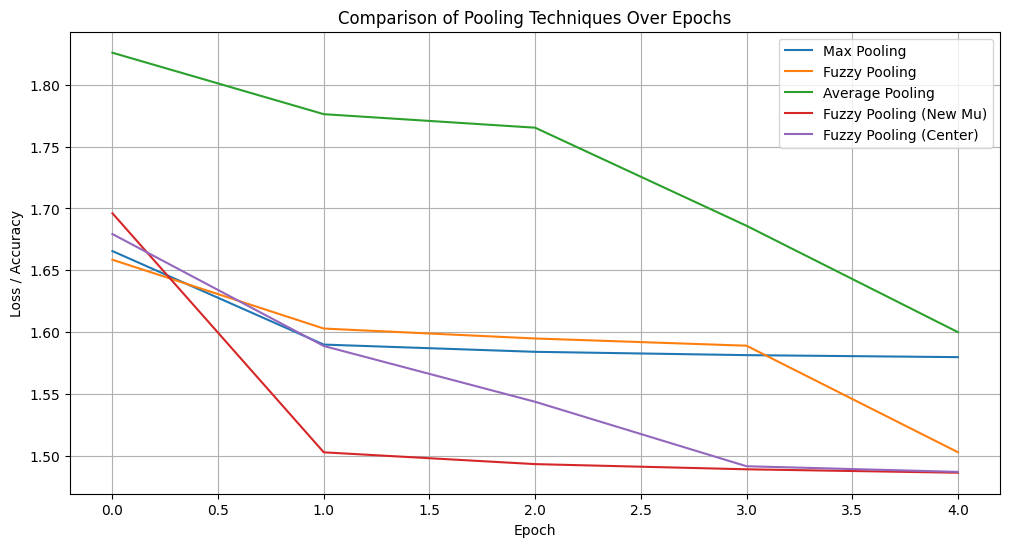

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(history_maxpool, label='Max Pooling')
plt.plot(history_fuzzypool, label='Fuzzy Pooling')
plt.plot(history_avgpool, label='Average Pooling')
plt.plot(history_fuzzypool_new_mu, label='Fuzzy Pooling (New Mu)')
plt.plot(history_fuzzypool_center, label='Fuzzy Pooling (Center)')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Comparison of Pooling Techniques Over Epochs')
plt.legend()
plt.grid(True)
plt.show()